# Scenario

In deze notebook ga ik stap voor stap door de data die we gebruiken voor de video over de extreme infospheren op YouTube.

Doelen van de video: 

1. Kijkers laten zien hoe groot en extreem deze infospheren zijn. 
2. Kijkers bekend maken met de belangrijkste ideeen en richtingen in deze infospheren.

Dit doen we door telkens te wisselen tussen macroniveau (hoe ziet die sphere eruit als je erboven hangt, dus hoe verhouden kanalen zich tot elkaar, tot andere spheres en tot andere media) en microniveau (wat gebeurt er nu eigenlijk in en onder die video's, hoe gedragen reaguurders zich?)

Daarvoor hebben we deze graphics nodig die de rode draad vormen van het scenario.

1. Belang YT in mediaconsumptie
2. Relatieve omvang van de spheres op YT (socialblade).
3. Aard en omvang van kanalen, verteld aan de hand van enkele representatieve kanalen.
4. Groei van de spheres - gapminder (10 geselecteerden) / onderwerp
5. Onderwerpen die behandeld worden (4 of 5, waaronder antifeminisme, biologisch racisme, vluchtelingen en migratie, antisemitisme, islamofobie.
6. Inzoomen op enkele reaguurders-communities (op groepsniveau en enkele individuen)

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime as dt
import glob 
import csv 
import re
import sys
import os

csv.field_size_limit(sys.maxsize)
%matplotlib inline

In [2]:
path_nl = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/NL/'
path_right = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/right/'
path_left = '/home/dim/Documents/projecten/extremisme/youtube/yt/YouTubeExtremism/DataCollection/output/left/'

## Belang YT in mediaconsumptie

Bronnen: 

1. [Mediamonitor 2018](https://www.cvdm.nl/wp-content/uploads/2018/06/Mediamonitor-2018-Reuters-Institute-Digital-News-Report-Nederland-2018.pdf)
2. [Marketingfacts](https://www.marketingfacts.nl/berichten/jongeren-keren-facebook-massaal-de-rug-toe)
3. [Pew research center](http://www.pewinternet.org/2018/05/31/teens-social-media-technology-2018/)



In [3]:
# Marketingfacts, percentage dat ... gebruikt.

data = {'WhatsApp':[97, 93, 86, 67, 38],
        'Facebook':[72, 89, 77, 69, 58],
        'YouTube':[86, 74, 54, 38, 21],
        'LinkedIn':[12, 45, 36, 14, 7],
        'Instagram':[73, 46, 22, 9, 6],
        'Twitter':[23, 26, 21, 9, 9],
        'Pinterest':[19, 30, 21, 12, 8],
        'Snapchat':[72, 32, 7, 1, 1]       
       }

marketingfacts = pd.DataFrame.from_dict(data, orient='index',
                             columns=['15-19 jaar', '20-39 jaar', '40-64 jaar', '65-79 jaar', '80+'])

In [4]:
marketingfacts

,15-19 jaar,20-39 jaar,40-64 jaar,65-79 jaar,80+
WhatsApp,97,93,86,67,38
Facebook,72,89,77,69,58
YouTube,86,74,54,38,21
LinkedIn,12,45,36,14,7
Instagram,73,46,22,9,6
Twitter,23,26,21,9,9
Pinterest,19,30,21,12,8
Snapchat,72,32,7,1,1


In [5]:
# Pew, perentage tieners die 

data = {'Youtube': [85, 32],
        'Instagram': [72, 15],
        'Snapchat': [69, 35],
        'Facebook': [51, 10],
        'Twitter': [32, 3],
        'Tumblr': [9, 1],
        'Reddit': [7, 1],
        'Geen van bovenstaande': [3, 3]
       }

pew = pd.DataFrame.from_dict(data, orient='index',
                            columns=['Zegt te gebruiken', 'Zegt het meest te gebruiken'])

In [6]:
pew

,Zegt te gebruiken,Zegt het meest te gebruiken
Youtube,85,32
Instagram,72,15
Snapchat,69,35
Facebook,51,10
Twitter,32,3
Tumblr,9,1
Reddit,7,1
Geen van bovenstaande,3,3


## Relatieve omgang van de spheres

Socialblade gebruikt een eigen ranking die gebaseerd is op viewcount, subscribercount en nog een paar zaken die ze niet openbaar heeft gemaakt. Dit geeft een idee waar we bepaalde kanalen moeten plaatsen binnen YouTube, hoe groot en invloedrijk ze zijn. 

Enkele voorbeelden:

Volkskrant ranks:
- Grade: C+
- Subscriber rank: 1,001,161st
- Video view rank: 502,428th
- Socialblade rank: 523,376th
- Estimated Monthly Earnings: €29 - €459
- Estimated Yearly Earnings: €344 - €5.5K

De Correspondent ranks:
- Grade: C
- Subscriber rank: 1,832,426th
- Video view rank: 5,212,726th
- Socialblade rank: 4,469,657th
- Estimated Monthly Earnings: €0.47 - €8
- Estimated Yearly Earnings: €6 - €90

The New York Times ranks:
- Grade: B+
- Subcriber rank: 5,443rd
- Video view rank: 3,210th
- Socialblade rank: 8,201st
- Estimated Monthly Earnings: €5.2K - €82.4K
- Estimated Yearly Earnings: €61.8K - €989.2K


In [7]:
# Er komt flink wat herhaling aan te pas, dus laten we een functie maken die de socialblade data opschoont.

def rank_channels(channel_ranking):
    '''de functie neemt een dataframe en 
    schoont de kolommen op'''
    channel_ranking['Source Url'] = channel_ranking['Source Url'].str.replace('https://socialblade.com/youtube/channel/', '')
    channel_ranking['Subscriber_Rank'] = channel_ranking['Subscriber_Rank'].replace('\D', '', regex=True).apply(pd.to_numeric)
    channel_ranking['Video_View_Rank'] = channel_ranking['Video_View_Rank'].replace('\D', '', regex=True).apply(pd.to_numeric)
    channel_ranking['Sb_Rank'] = channel_ranking['Sb_Rank'].replace('\D', '', regex=True).apply(pd.to_numeric)
    channel_ranking['earnings_low'], channel_ranking['earnings_high'] = channel_ranking['Estimated_Yearly_Earning'].str.split('-', 1).str
    channel_ranking['earnings_low'] = channel_ranking['earnings_low'].replace('st|th|rd|nd', '', regex=True)
    channel_ranking['earnings_high'] = channel_ranking['earnings_high'].replace('st|th|rd|nd', '', regex=True)
    channel_ranking = channel_ranking.rename(columns={'Source Url': 'channel_id',
                                                    'Subscriber_Rank': 'subscriber_rank',
                                                    'Video_View_Rank': 'video_view_rank',
                                                    'Sb_Rank': 'sb_rank',
                                                    'Grade': 'grade'
                                               })
    return channel_ranking

In [8]:
channel_ranking = pd.read_csv(path_nl + 'other_platforms/socialblade_nl_right_summary.csv')
channel_ranking_nl = rank_channels(channel_ranking)
channel_ranking_nl['sphere'] = 'nl_right'
channels_nl = pd.read_csv(path_nl + 'channels_nl_right.csv')
ranking_nl = pd.merge(channel_ranking_nl, channels_nl, on='channel_id', how='left')

In [9]:
channel_ranking = pd.read_csv(path_right + 'other_platforms/socialblade_right_summary.csv')
channel_ranking_right = rank_channels(channel_ranking)
channel_ranking_right['sphere'] = 'int_right'
channels_right = pd.read_csv(path_right + 'channels_right.csv')
ranking_right = pd.merge(channel_ranking_right, channels_right, on='channel_id', how='left')

In [10]:
channel_ranking = pd.read_csv(path_left + 'other_platforms/socialblade_left_summary.csv')
channel_ranking_left = rank_channels(channel_ranking)
channel_ranking_left['sphere'] = 'int_left'
channels_left = pd.read_csv(path_left + 'channels_left.csv')
ranking_left = pd.merge(channel_ranking_left, channels_left, on='channel_id', how='left')

In [11]:
rankings_total = ranking_nl.append([ranking_left, ranking_right])

In [12]:
rankings_total.sort_values('sb_rank')

,channel_id,Uploads,Subscribers,Videoviews,Country,grade,subscriber_rank,video_view_rank,sb_rank,Estimated_Yearly_Earning,...,channel_default_language,channel_country,channel_uploads,channel_viewcount,channel_commentcount,channel_subscribercount,channel_videocount,channel_topic_ids,channel_topic_categories,channel_branding_keywords
0,UC1yBKRuGpC1tSM73A0ZjYjQ,"34,807","4,227,080","4,501,798,901",US,B+,1266.0,227.0,2108.0,115.5K - €1.8M,...,not set,US,UU1yBKRuGpC1tSM73A0ZjYjQ,4.483197e+09,0.0,4229161.0,34672.0,"['/m/05qt0', '/m/05qt0', '/m/098wr']","['https://en.wikipedia.org/wiki/Society', 'htt...","news politics tyt ""young turks"" ""the young tur..."
79,UCIveFvW-ARp_B_RckhweNJw,800,"3,091,587","626,998,405",US,B+,2088.0,3433.0,2489.0,84.6K - €1.4M,...,not set,not set,UUIveFvW-ARp_B_RckhweNJw,6.285336e+08,0.0,3101925.0,800.0,"['/m/02jjt', '/m/098wr']","['https://en.wikipedia.org/wiki/Society', 'htt...",Steven Crowder Louder With Politics Conservati...
115,UCZWlSUNDvCCS1hBiXV0zKcA,493,"1,854,550","552,298,563",US,B+,4402.0,3998.0,3298.0,86.9K - €1.4M,...,not set,US,UUZWlSUNDvCCS1hBiXV0zKcA,5.543337e+08,0.0,1857495.0,494.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],"""prager university"" prager ""dennis prager"" pra..."
1,UCsqjHFMB_JYTaEnf_vmTNqg,342,"2,296,555","549,340,953",US,B+,3267.0,4018.0,4012.0,68.1K - €1.1M,...,not set,not set,UUsqjHFMB_JYTaEnf_vmTNqg,5.375717e+08,0.0,2255404.0,338.0,"['/m/07yv9', '/m/019_rr']","['https://en.wikipedia.org/wiki/Vehicle', 'htt...",not set
37,UCaeO5vkdj5xOQHp4UmIN6dw,"2,896","1,114,265","219,562,403",US,B+,8679.0,11607.0,5293.0,51.1K - €817.4K,...,not set,US,UUaeO5vkdj5xOQHp4UmIN6dw,2.204370e+08,0.0,1117311.0,2918.0,"['/m/05qt0', '/m/05qt0', '/m/098wr']","['https://en.wikipedia.org/wiki/Politics', 'ht...","""The Daily Wire"" ""Daily Wire"" ""Ben Shapiro"" ""A..."
613,UCgV-hgprraRb071mumQFw2g,13,"162,439","23,889,194",US,B+,66305.0,113601.0,8263.0,18.2K - €291.8K,...,not set,US,UUgV-hgprraRb071mumQFw2g,2.404829e+07,0.0,163126.0,13.0,"['/m/0glt670', '/m/0glt670', '/m/04rlf']","['https://en.wikipedia.org/wiki/Music', 'https...",not set
127,UCe02lGcO-ahAURWuxAJnjdA,440,"122,819","27,450,921",NaN,B,85993.0,100993.0,16358.0,21.7K - €347.8K,...,not set,not set,UUe02lGcO-ahAURWuxAJnjdA,2.794160e+07,0.0,123873.0,446.0,"['/m/098wr', '/m/098wr']",['https://en.wikipedia.org/wiki/Society'],politics
26,UC0rZoXAD5lxgBHMsjrGwWWQ,"3,953","320,417","124,034,333",US,B,34383.0,21544.0,16789.0,24.2K - €387.9K,...,not set,US,UU0rZoXAD5lxgBHMsjrGwWWQ,1.245075e+08,0.0,321387.0,3957.0,"['/m/098wr', '/m/019_rr', '/m/05qt0']","['https://en.wikipedia.org/wiki/Politics', 'ht...","""current events"" ""tarl warwick"" politics occul..."
146,UCy-N04M3rGQMznjIv5g2LGQ,315,0,"26,023,268",GB,B,24218778.0,107455.0,17451.0,18.2K - €290.6K,...,not set,GB,UUy-N04M3rGQMznjIv5g2LGQ,2.649125e+07,0.0,0.0,316.0,"['/m/05qt0', '/m/05qt0', '/m/098wr']","['https://en.wikipedia.org/wiki/Society', 'htt...",not set
5,UCvixJtaXuNdMPUGdOPcY8Ag,"18,150","543,830","373,338,213",US,B,19669.0,6382.0,17563.0,20.9K - €334.9K,...,not set,US,UUvixJtaXuNdMPUGdOPcY8Ag,3.696483e+08,0.0,536287.0,18083.0,"['/m/05qt0', '/m/098wr']","['https://en.wikipedia.org/wiki/Society', 'htt...","""the david pakman show"" politics news republic..."


Misschien is het interessant om een verdeling te maken van hoe hoog de verschillende sferen (links/rechts) scoren. Ook moeten we nog even kritisch kijken of we alle kanalen er wel in willen hebben. Bij sommige hebben we twijfels. Die kunnen we er even uitfilteren. 


In [13]:
# Vul hier de kanalen in die je niet wilt

ongewenste_kanalen = []

rankings_total = rankings_total[~rankings_total['channel_title'].isin(ongewenste_kanalen)]

## Groei van de spheres

Hiervoor gebruiken we in eerste instantie cijfers van socialblade.com. Probleem is dat die maar teruggaan tot 2015. Dus ik wil ook nog de video's gebruiken. Probleem is alleen dat die cijfers minder kloppen omdat oude videos relatief hoge viewcounts hebben, omdat die lang nadien nog bekeken kunnen worden. Een video uit 2011 kan nu nog steeds viewcounts krijgen. Socialblade bakent dit af per maand, dus is nauwkeuriger. Maar laten we het gewoon allebei proberen. 

In [14]:
channel_history_nl = pd.read_csv(path_nl + 'other_platforms/socialblade_nl_monthly.csv')
channel_history_right = pd.read_csv(path_right + 'other_platforms/socialblade_right_monthly.csv')
channel_history_left = pd.read_csv(path_left + 'other_platforms/socialblade_left_monthly.csv')
channel_history_nl['sphere'] = 'nl_right'
channel_history_right['sphere'] = 'int_right'
channel_history_left['sphere'] = 'int_left'
channel_history = channel_history_nl.append([channel_history_left, channel_history_right])
channel_history = channel_history.rename(columns={'User':'channel_id'})
len(channel_history)

1402

In [15]:
channel_history.head()

,Source Url,channel_id,Date_Daily_Subs,Date_Total_Subs,Date_Daily_Views,Date_Total_Views,Date_Average_Views,Date_Monthly_Views,sphere
0,https://socialblade.com/youtube/channel/UCmboH...,UCmboH8kxYUEQ9p4t7IrgL-Q,"2017-03-16,10\n"" + ""2017-03-17,1\n"" + ""2017-03...","+ ""2017-03-16,360\n"" + ""2017-03-17,370\n"" + ""2...","2017-03-16,136\n"" + ""2017-03-17,443\n"" + ""2017...","2017-03-16,14094\n"" + ""2017-03-17,14230\n"" + ""...","2017-03-1,70\n"" + ""2017-04-1,75\n"" + ""2017-05-...","2017-03-1,2196\n"" + ""2017-04-1,2250\n"" + ""2017...",nl_right
1,https://socialblade.com/youtube/channel/UCaEYL...,UCaEYLMXh96lyMfVwGhVzDZA,"2015-06-30,0\n"" + ""2015-07-01,0\n"" + ""2015-07-...","+ ""2015-06-30,316\n"" + ""2015-07-01,316\n"" + ""2...","2015-06-30,0\n"" + ""2015-07-01,1810400\n"" + ""20...","2015-06-30,1810400\n"" + ""2015-07-01,0\n"" + ""20...","2015-06-1,0\n"" + ""2015-07-1,-58180\n"" + ""2015-...","2015-06-1,0\n"" + ""2015-07-1,-1803574\n"" + ""201...",nl_right
2,https://socialblade.com/youtube/channel/UCVVpl...,UCVVplPd75SucSkTvuW4bW-w,"2017-06-16,9\n"" + ""2017-06-17,1\n"" + ""2017-06-...","+ ""2017-06-16,34\n"" + ""2017-06-17,43\n"" + ""201...","2017-06-16,0\n"" + ""2017-06-17,7507\n"" + ""2017-...","2017-06-16,7945\n"" + ""2017-06-17,7945\n"" + ""20...","2017-06-1,537\n"" + ""2017-07-1,28\n"" + ""2017-08...","2017-06-1,16128\n"" + ""2017-07-1,874\n"" + ""2017...",nl_right
3,https://socialblade.com/youtube/channel/UC9H9K...,UC9H9K7oSpte0uWBofdW4UiA,"2016-09-25,34\n"" + ""2016-09-26,26\n"" + ""2016-0...","+ ""2016-09-25,1769\n"" + ""2016-09-26,1803\n"" + ...","2016-09-25,0\n"" + ""2016-09-26,34237\n"" + ""2016...","2016-09-25,188341\n"" + ""2016-09-26,188341\n"" +...","2016-09-1,2779\n"" + ""2016-10-1,2038\n"" + ""2016...","2016-09-1,83392\n"" + ""2016-10-1,63188\n"" + ""20...",nl_right
4,https://socialblade.com/youtube/channel/UCCEuh...,UCCEuhjaT09ArS77AJm6etXw,"2015-06-17,-2\n"" + ""2015-06-18,3\n"" + ""2015-06...","+ ""2015-06-17,2651\n"" + ""2015-06-18,2649\n"" + ...","2015-06-17,934\n"" + ""2015-06-18,845\n"" + ""2015...","2015-06-17,1478741\n"" + ""2015-06-18,1479675\n""...","2015-06-1,10671\n"" + ""2015-07-1,2077\n"" + ""201...","2015-06-1,320159\n"" + ""2015-07-1,64401\n"" + ""2...",nl_right


In [16]:
# Extract all the dates and values of two columns: daily views and total subs

pattern = re.compile('(\d{4}-\d{2}-\d+,\d+)')

# And create two new columns with lists of dates and values found

channel_history['daily_views'] = channel_history['Date_Daily_Views'].str.findall(pattern)
channel_history['daily_subs'] = channel_history['Date_Total_Subs'].str.findall(pattern)

# Stack them, so all the dates and values are linked to the channels and
# we are getting rid of the messy lists.

daily_views = channel_history.set_index('channel_id') \
            .daily_views.apply(pd.Series) \
            .stack() \
            .reset_index(level=-1, drop=True) \
            .reset_index()

# Extract the values columns for views and subscriptions (subs)

daily_views['date'], daily_views['views'] = daily_views[0].str.split(',', 1).str
daily_views = daily_views[['channel_id', 'date', 'views']]

daily_subs = channel_history.set_index('channel_id') \
            .daily_subs.apply(pd.Series) \
            .stack() \
            .reset_index(level=-1, drop=True) \
            .reset_index()

daily_subs['date'], daily_subs['subs'] = daily_subs[0].str.split(',', 1).str
daily_subs = daily_subs[['channel_id', 'date', 'subs']]

# And bring it all together in a dataframe called daily_stats

daily_stats = pd.merge(daily_subs, daily_views,  how='left', left_on=['channel_id', 'date'], right_on = ['channel_id', 'date'])


In [17]:
stats = pd.merge(daily_stats, channel_history[['channel_id', 'sphere']])

In [18]:
channels_nl = pd.read_csv(path_nl + 'channels_nl_right.csv')
channels_left = pd.read_csv(path_left + 'channels_left.csv')
channels_right = pd.read_csv(path_right + 'channels_right.csv')
channels_nl['sphere'] = 'nl_right'
channels_left['sphere'] = 'int_left'
channels_right['sphere'] = 'int_right'
channels_total = channels_nl.append([channels_left, channels_right])

In [ ]:
len(channels_total)

1805

In [ ]:
stats_final = pd.merge(stats, channels_total[['channel_id', 'channel_title']], on='channel_id', how='left')

In [ ]:
stats_channels = stats_final.dropna()

In [ ]:
stats_channels['yearmonth'] = pd.to_datetime(stats_channels['date']).dt.to_period('M')

/home/dim/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
len(stats_channels)

1290029

In [ ]:
monthly_stats = stats_channels[['channel_title', 'yearmonth', 'subs', 'views', 'sphere']]
monthly_stats.to_csv('output/montly_statistics_for_scenario.csv', index=False)

Laten we een subset nemen, want dit is wel erg veel.

Voorstel:

- 'Stefan Molyneux', (bekend en al sinds 2008 actief)
- 'Red Ice TV', (populair en Europees)
- 'Millennial Woes', (invloedrijk, doch een behoorlijke randfiguur)
- 'Andywarski', (zou een gematigd figuur moeten zijn, maar biedt ruimte aan extremen. vernieuwend format)
- 'Alt-Right Tankie- Eurasianist', (hardcore alt-right)
- 'The Alternative Hypothesis', (idem, met interessant game-format)
- 'Rebel Media', (zeer hard gegroeid, behoorlijk professioneel)
- 'Styxhexenhammer666', (vertegenwoordigt het occulte deel)
- 'Jean-Francois Gariépy', (Franse biologische racist die ook veel met andere youtubers samenwerkt)
- 'Gavin McInnes', (antifeminist, veel in het nieuws)
- 'Politiekman', (een van de weinige NL alt-right youtubers. recentelijk gestopt)
- 'Black Pigeon Speaks', (bekend kanaal, mag eventueel afvallen)
- 'Paul Joseph Watson', (vertegenwoordigt het conspiracy-deel. zeer populair)
- 'The Thinkery', (filosofische tak)
- 'Sargon of Akkad', (groot en directe relatie met de gamergate controverse)
- 'American Rennaissance', (white supremacy)
- 'Pat Condell', (zeer populair in NL, lijkt tanend te zijn)
- 'Vlad Tepesblog', (counter-jihadism. Loopt lang mee, en nog steeds populair)
- 'The Iconoclast', (hardcore alt-right)
- 'Dr. Steve Turley', (christelijke tak)
- 'Black Pilled', (hardcore alt-right, black pilled verwijst doorgaans naar incels)
- 'Blonde in the Belly of the Beast', (vrouw!)
- 'Brittany Pettibone', (vrouw, populair en omstreden)
- 'T Я U Σ Ð I L T O M', (brit, bedient zich van de fashwave stijl)
- 'AltRight.com' (kanaal van Richard Spencer)

In [ ]:
chans_we_want = ['Stefan Molyneux',
                 'Red Ice TV',
                 'Millennial Woes',
                 'Andywarski',
                 'Alt-Right Tankie- Eurasianist',
                 'The Alternative Hypothesis',
                 'Rebel Media',
                 'Styxhexenhammer666',
                 'Jean-Francois Gariépy',
                 'Gavin McInnes',
                 'Politiekman',
                 'Black Pigeon Speaks',
                 'Paul Joseph Watson',
                 'The Thinkery',
                 'Sargon of Akkad',
                 'American Rennaissance',
                 'Pat Condell',
                 'Vlad Tepesblog',
                 'The Iconoclast',
                 'Dr. Steve Turley',
                 'Black Pilled',
                 'Blonde in the Belly of the Beast',
                 'Brittany Pettibone',
                 'T Я U Σ Ð I L T O M',
                 'AltRight.com'
]

In [ ]:
videos_right = pd.read_csv(path_right + 'videos_right.csv', encoding='latin-1')
videos_right.loc[:,('year')] = pd.to_datetime(videos_right.loc[:,('video_published')]).dt.to_period('Y')
videos_right.loc[:,('yearmonth')] = pd.to_datetime(videos_right.loc[:,('video_published')]).dt.to_period('M')

In [ ]:
vids_we_want = videos_right[videos_right['video_channel_title'].isin(chans_we_want)]
len(vids_we_want)

28645

In [ ]:
vids_grouped = vids_we_want.groupby(['video_channel_title', 'yearmonth'])[['video_view_count',
                                                                           'video_comment_count',
                                                                           'video_likes_count'
                                                                          
                                                                          ]].agg('sum')

In [ ]:
vids_grouped.to_csv('output/vids_selection_monthly_statistics.csv')

Je kunt de gapminder-file [hier](https://drive.google.com/open?id=1g_7d73CTTffv4hrLeI8UMSFGUTLvu4ax) vinden.

## Waar gaan de videos over?

Laten we eerst kijken naar alle videos. Enkele onderwerpen die ik wil onderzoeken zijn:
1. De manosphere
2. Ras en IQ
3. Geweld
4. Antisemitisme
5. Anti-moslim
6. Vluchtelingen / migratie

Later kunnen we nog een paar andere onderwerpen eruit pakken en de selectie wat kleiner maken.

Ik ben naar een aantal dingen benieuwd.
1. Een aantal basale statistieken. Hoeveel komt een onderwerp voor? Wie maakt ze? Wanneer speelde het?
2. Zijn er content producers die opvallen? Wat voor content maken ze? Wat is de toon?
3. Welke relatie heeft het kanaal met andere kanalen? Daarbij wil ik kijken naar de commenters - waar zijn die nog meer actief? 
4. En we zouden nog kunnen kijken naar de aanbevelingen van de gevonden video's. 

Allereerst wil ik de tags gebruiken. Die zie je als gebruiker niet, maar die worden wel steevast door contentmakers aangemaakt en zijn best wel onthullend. Plus ook redelijk betrouwbaar lijkt me: het maakt hun content immers beter vindbaar. Later kunnen we ook nog andere technieken gebruiken, zoals topic modelling, maar dat lijkt me vooralsnog wat zwaar geschut.

### Manosphere

Goed, eerst de manosphere. Met onderstaande termen moeten we de videos kunnen vinden. De kunst is om de termen zo precies en afgebakend mogelijk te houden. Wat mij betreft kiezen we ook vrij extreme termen, zodat over de aard van de content, of extremiteit zo je wil, niet zoveel discussie hoeft te zijn.

In [ ]:
query_topic = 'manosphere'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['mgtow', 'metoo', '^rape', 'rape cultur','proud boys', 'incel', 
         'pickup arti', 'rooshv', "men's right", 
         'men rights', 'manospher', 'mascul', 'hypergam', 
         'gynocentr', 'briffault', 'gold digg', 'whores', 
         'vagina', 'parasitic women', 'mens righ',
         'alpha fucks', 'misandry', 'alfa fux'
        ]


In [ ]:
pattern = '|'.join([s for s in query])
mask = videos_right['video_tags'].str.contains(pattern, regex=True, case=False, na=False)
topic = videos_right[mask]

len(topic)

2941

We vinden dus 2941 video's die een van deze termen in hun tags hebben. Wat is hun totale viewcount?

In [ ]:
topic.video_view_count.sum()

221003323.0

Wow, meer dan 220 miljoen! Vermoedelijk is het een stuk minder als je metoo weghaalt. We zouden de selectie nog wat extremer kunnen maken.

In [ ]:
query_more_extreme = ['mgtow', '^rape', 'rape cultur','proud boys', 'incel', 
         'pickup arti', 'rooshv', "men's right", 
         '^men rights', 'manospher', 'hypergam', 
         'gynocentr', 'briffault', 'gold digg', 'whores', 
         'vagina', 'parasitic women', 'mens righ',
         'alpha fucks', 'misandry', 'alfa fux'
        ]

In [ ]:
pattern = '|'.join([s for s in query_more_extreme])
mask = videos_right['video_tags'].str.contains(pattern, regex=True, case=False, na=False)
topic_more_extreme = videos_right[mask]

len(topic_more_extreme)

2438

In [ ]:
topic_more_extreme.video_view_count.sum()

187153361.0

Nou ja, ook nog steeds veel. 190 miljoen views, afgerond.

topic.to_csv('output/scenario/tags_all_videos_' + query_topic + '.csv')

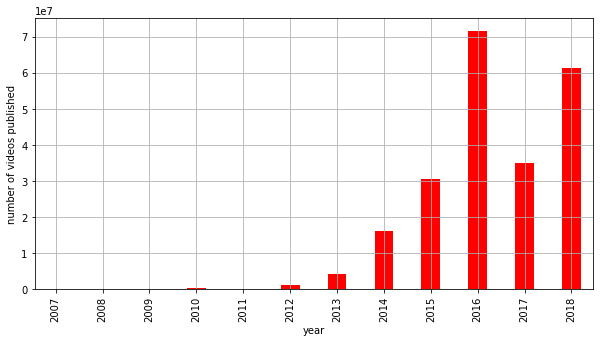

In [ ]:
views_per_year = topic.groupby(['year'])['video_view_count'].agg('sum')

fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4
ax = fig.add_subplot(111) 

views_per_year.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('year')

plt.show()

Een opmerkelijke piek in 2016. Daarna een vrij plotselinge afname en weer een flinke toename dit jaar. Wat zou dat kunnen verklaren? 

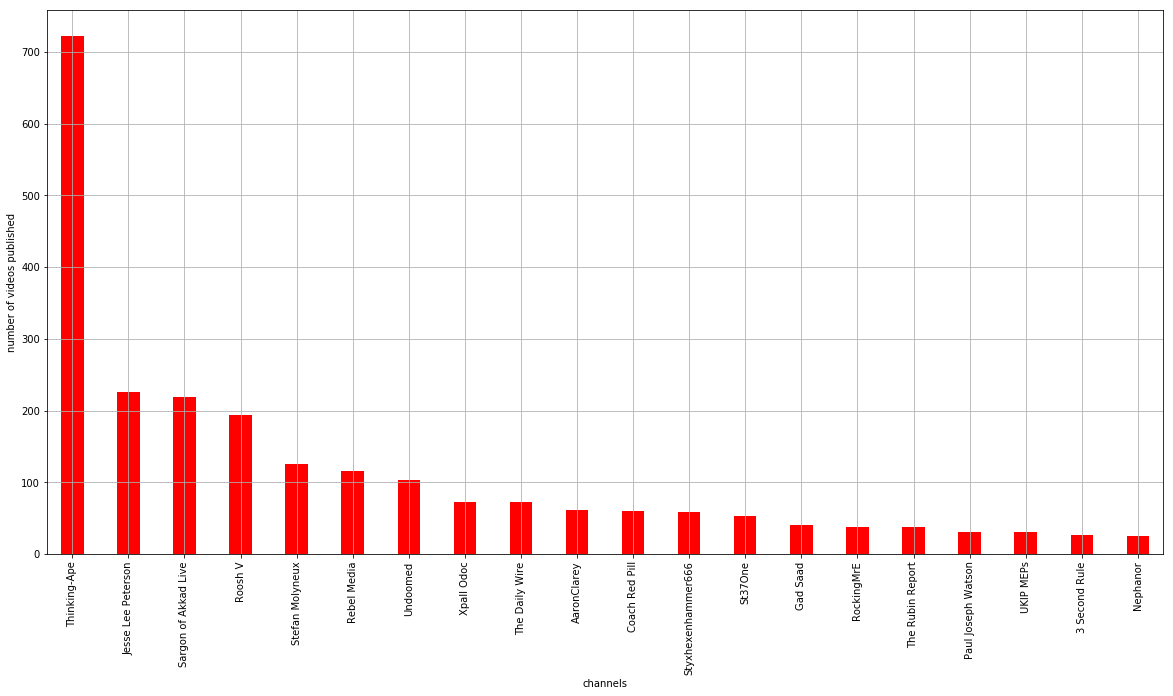

In [ ]:
top_channels = topic['video_channel_title'].value_counts()[0:20]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

top_channels.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('channels')

plt.show()

Het lijkt me vrij duidelijk wie bovenop dit onderwerp zit: Thinking Ape. Hij publiceert al jaren zeer actief (722 videos). Laten we hem eens wat nader bekijken. Ik ben ook wel benieuwd naar Jessie Lee Peterson en eigenlijk kan ook Roosh V niet ontbreken. Sargon verdient volgens mij een eigen analyse, net als Stefan Molyneux. 

#### Manosphere - Thinking Ape

In [ ]:
channel_of_interest = 'Thinking-Ape'

manosphere = topic[topic['video_channel_title'] == channel_of_interest]
len(manosphere)

722

Hoevaak zijn zijn video's bekeken?

In [ ]:
manosphere.video_view_count.sum()

5965792.0

Wat is de verdeling van gemaakte video's over tijd? En de views over tijd?

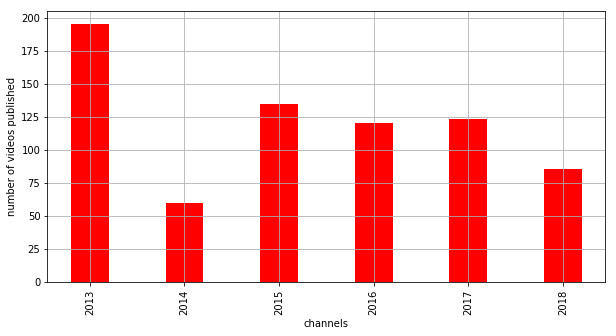

In [ ]:
uploads = manosphere.groupby('year').size()
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

uploads.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('channels')

plt.show()

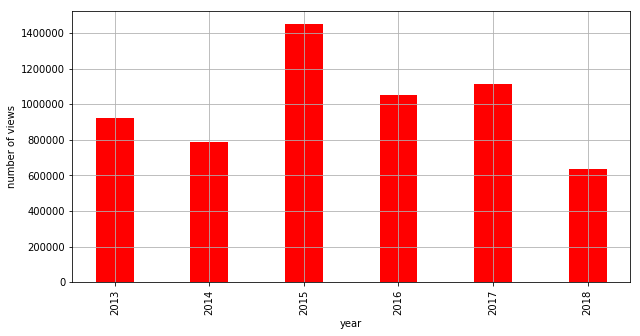

In [ ]:
views = manosphere.groupby('year')['video_view_count'].agg('sum')

fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

views.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of views')
ax.set_xlabel('year')

plt.show()

Het duurde blijkbaar even voordat zijn video's werden opgemerkt. Hoogtepunt was in 2015. Interessant, aangezien veel kanalen rond 2016 of daarna pieken.

Laten we eens kijken naar de tags die hij gebruikt. 

In [ ]:
vidtags = manosphere[['video_id', 'video_title', 'video_tags', 'year']]

video_tags = vidtags['video_tags'].str.replace(r"\[|\]|\'|-", '') \
                    .str.lower() \
                    .str.split(', ', expand=True) \
                    .merge(vidtags, right_index = True, left_index = True) \
                    .drop(["video_tags"], axis = 1) \
                    .melt(id_vars = ['video_id', 'video_title', 'year'], value_name = "tag") \
                    .drop(['variable'], axis=1) \
                    .dropna()

#video_tags = video_tags[~video_tags['tag'].str.contains('not set')]
#video_tags.sort_values('tag', inplace=True)
video_tags.tag.nunique()

video_tags['tag'] = video_tags['tag'].str.replace('"', '')
video_tags.tag.value_counts()

stardusk                                 720
feminism                                 705
hypergamy                                697
briffaults law                           688
gynocentrism                             683
marriage                                 681
male disposability                       681
traditionalism                           676
divorce                                  674
separation                               665
alimony                                  650
women initiate divorce                   627
prostitutes                              621
masculinity                              619
femininity                               614
legal prostitution                       614
women and children first                 591
child support                            589
male expendability                       586
mangina                                  581
gold diggers                             578
white knight                             573
biology   

Even een verklarende woordenlijst:
    
1. Stardusk is [een YouTube-kanaal over MGTOW](https://youtube.com/user/Stardusk/videos). Het zou mij niets verbazen als dit ook van Thinking Ape is omdat hij zichzelf ook zo noemt.
2. Hypergamy is boven je strand trouwen, dus 'marrying up' of 'gold digging'. Zie [Wikipedia](https://en.wikipedia.org/wiki/Hypergamy).
3. Briffault's Law stelt, in hele simpele vorm, dat vrouwen eigenlijk de ultieme baas zijn (zie [dit artikel](https://www.psychologytoday.com/us/blog/machiavellians-gulling-the-rubes/201610/briffaults-law-women-rule) voor extra uitleg).
4. De naam zegt het eigenlijk al, bij gynocentrism draait alles om het gezichtspunt van de vrouw, zie [Wikipedia](https://en.wikipedia.org/wiki/Gynocentrism).
5. Male disposability, ook al zo'n deerniswekkend concept. Blijkbaar ook Male Expandability genoemd, zie [Wikipedia](https://en.wikipedia.org/wiki/Male_expendability).
6. Women initiate divorce slaat op de statistiek dat negentig procent van de echtscheidingen door vrouwen in gang wordt gezet. Zie bijvoorbeeld het [MGTOW-forum](https://www.mgtow.com/forums/topic/80-percent-of-divorces-are-initiated-filed-by-women/)

Meneer heeft trouwens 253 patrons [op patreon.](https://www.patreon.com/user?u=257125)

Al met al zijn die tags behoorlijk grof en vijandig. Opvallend dus ook: die tags is niet wat je in de normale interface van YT ziet. We zouden die tags ook nog over tijd kunnen plotten om iets van een ontwikkeling te zien. Ik weet niet of dat echt veel oplevert in dit geval, maar dan hebben we de code alvast om dat te doen.

In [ ]:
tags_per_year = video_tags.groupby(['tag', 'year']).size().reset_index(name='counts')

# Geef een minimale hoeveelheid aan dat een tag voor moet komen, anders hebben we gewoon teveel.

minimum = 25

tags_per_year = tags_per_year[tags_per_year['counts'] >= minimum]

In [ ]:
tags_per_year.sort_values('year', inplace=True)

In [ ]:
# Schrijf 't naar een csv, zodat we het in gapminder kunnen zien.

tags_per_year.to_csv('output/scenario/tags_per_year_for_' + channel_of_interest + '_.csv', index=False)

TODO: nog even de file aanpassen omdat gapminder 'm niet goed laadt.

Laten we eens naar wat video's gaan kijken. Ik maak een vrij expliciete selectie, bijvoorbeeld op 'whores'.

In [ ]:
lookup = video_tags[video_tags['tag'].str.contains('whores')]

In [ ]:
lookup

,video_id,video_title,year,tag
3948,NreA_Sx6m7E,The Riddle Of The Pumpkin Spice Latte,2015,whores
4626,Qlr2eM8nP9w,"Perspectives: Spain, The Long Decline",2016,whores
5345,t8eTAsJVnNU,"MGTOW Talks: The Alt-Right, Population Genetic...",2016,whores
5374,bNhMyxU8NJI,Perspectives: Nigeria and the Reality of the 3...,2016,whores
5482,YRQTNHRmAKw,"Language/Dialect Distinction, the Politics of...",2015,whores
5808,OdmTF-a66wE,Anthony Bourdain | Reflections On Suicide And ...,2018,whores
6047,S6heBTvaekc,"Youth, Society And Neurological Reality",2016,whores
6078,9jXGfPNS8Og,Perspectives: Denmark and the Nordic Model,2016,whores
6091,xvn2HqDG1-U,"MGTOW Talks: Ethnicity, Civilisation and Culture",2016,whores
6111,8EGN2KfFusM,Invasive Species and Human Maladaptation,2015,whores


Neem [deze video](https://www.youtube.com/watch?v=8EGN2KfFusM). Invasive species and Human Maladaptation. We zien niet veel. Een kaart van een Australie, met de titel: 'current extent and anticipated distribution of cane toads in australia'. De video gaat over de verdringingen van soorten door menselijk toedoen. Wat heeft dat met de tag 'whores' te maken? Verder is de video niet erg schokkend. Pas later in de video (zo rond 16:00 gaat het over psychologische maladaptation, dat steden bijvoorbeeld verantwoordelijk zijn voor echtscheidingen). Hoe vrouwen zich in stedelijke gebieden gedragen en hoe in rurale gebieden. 

Of [deze video](https://www.youtube.com/watch?v=_XaJHKl8kAY): MGTOW Talks: SJWs And the Blue Pill Rebellion in Gaming. Een gesprek van 1:20 uur, met een vaste gast (Australier en womanizer). Begint met de vraag of SJW's professionele trollen zijn. 'You can't appease these people'. Over gamergate en de Sarkeesian crowd. Opmerkelijke vorm ook: we zien de hele tijd een aankondiging voor een software conferentie. Waarom is dat? 

[Dit](https://www.youtube.com/watch?v=t8eTAsJVnNU) is ook wel een interessant voorbeeld. Lang (bijna twee uur durend gesprek), het is me niet helemaal duidelijk waar 'ie staat. Lijkt zich juist af te zetten tegen alt-right.

Aparte comment, lieflijk haast, spreekt wel over redpilling [zie](https://www.youtube.com/watch?v=Kx-4s1gGOkA&lc=UgjKEwvAkB7XkXgCoAEC)

Wellicht is het interessant om te kijken naar de commenters. Waar zitten die nog meer? Is dit kanaal, vanuit het perspectief van de reaguurders, deel van een bredere gemeenschap?

Stap 1: even de video_id's in een lijst zetten.

In [ ]:
manosphere_movies = set(manosphere.video_id)
len(manosphere_movies)

722

Stap 2: haal deze lijst door alle comments in het rechtse veld om de reaguurders te vinden.

In [ ]:
iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        chunksize=1000000, 
                        sep='¶',
                        quotechar='þ',
                        engine='python')
fappers = pd.concat([chunk[chunk['video_id'].isin(manosphere_movies)] for chunk in iter_csv])

len(fappers)

64403 comments gevonden op de video's van Thinking Ape.

Stap 3. Zoek waar deze commenters nog meer hebben gereageerd, zodat we iets kunnen zeggen over de infosphere waar ze inzitten.

In [ ]:
fappers_to_search = set(fappers.author_channel_id.unique())
len(fappers_to_search)

In [ ]:
iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        chunksize=1000000, 
                        sep='¶',
                        quotechar='þ',
                        engine='python')
faposphere = pd.concat([chunk[chunk['author_channel_id'].isin(fappers_to_search)] for chunk in iter_csv])

len(faposphere)

Van deze groep hebben we dus 1,3 miljoen comments gevonden. Waar zitten ze dan?

In [ ]:
fappers_united = pd.merge(faposphere, videos_right, on='video_id', how='left')

Waar zitten ze?

In [ ]:
channels = fappers_united.video_channel_title.value_counts()[0:20]
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

channels.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of views')
ax.set_xlabel('year')

plt.show()

Weinig verrassingen. Stefan Molyneux is wederom populair. Millennial Woes verbaasd me wel, evenals Jean Francois Gariepy. Zit dus lekker in de Alt-right.

Welke reaguurders vallen op?

In [ ]:
topfappers = fappers_united.author_display_name.value_counts()[0:20]
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

topfappers.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of views')
ax.set_xlabel('year')

plt.show()

Kijk eens aan. Hier komen we een aantal bekenden tegen, waaronder Mr.CoolMug die ook bij Erkenbrand actief is.
Een aantal anderen zijn ook prominent in de NL scene. Kan zijn dat ze overal prominent zijn en dus ook in de NL scene, maar het zou zo maar kunnen dat dit Nederlanders zijn. 

Ik ga eens kijken naar de ultime topfapper, Siim Land en wat zijn pad is in de Alt-right scene.

In [ ]:
siim = fappers_united[fappers_united['author_display_name'] == 'Siim Land']

Even checken of het echt 1 en dezelfde persoon is.

In [ ]:
siim.author_channel_id.nunique()

Ja, er is maar een channel id. Die zijn uniek, dus we hebben hier met 1 persoon te maken, of beter gezegd, 1 account. Ik ga het even in [rawgraph](http://rawgraphs.io) bekijken. We hebben niet alle data nodig daarvoor, dus ik maak even een selectie.

In [ ]:
siim_grouped = siim.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
siim_grouped

Aha. Hij heeft zijn eigen kanaal waar hij erg actief is. Dat is dus niet zo interessant. Laten we dan maar Mr.CoolMug nemen. 

In [ ]:
mr_cool = fappers_united[fappers_united['author_display_name'] == 'MrCool Mug']
mr_cool.author_channel_id.nunique()

In [ ]:
mr_cool_grouped = mr_cool.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
mr_cool_grouped.to_csv('output/scenario/raw_graph_mr_cool_mug.csv')
mr_cool_grouped

Oke, MrCool Mug zit zo'n beetje overal. Wel een interessante casus hoor. Zie een niet al te beste weergave van zijn ontwikkeling [hier.](https://drive.google.com/open?id=1wCQS-o85-FknSLovHJVjYiovGxH7TVQX) 

Laten we dan toch nog even op zoek gaan naar een hardcore mgtow-er die onder veel mgtow-video's reageert. We zoomen dus weer even uit naar de gemeenschap als geheel.

In [ ]:
len(topic)

In [ ]:
topic_videos = set(topic.video_id)

In [ ]:
iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        chunksize=1000000, 
                        sep='¶',
                        quotechar='þ',
                        engine='python')
fappers = pd.concat([chunk[chunk['video_id'].isin(topic_videos)] for chunk in iter_csv])

len(fappers)

Dat zijn een boel fappers... You know the drill...

In [ ]:
fappers_united = pd.merge(fappers, videos_right, on='video_id', how='left')

In [ ]:
topfappers = fappers_united.author_display_name.value_counts()[0:20]
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

topfappers.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of views')
ax.set_xlabel('year')

plt.show()

Ook hier zien we weer Mistah Susan hoog staan. Misschien is die wel interessant. Hoewel, feminazi frequency ook intrigeert.

In [ ]:
mistah = fappers_united[fappers_united['author_display_name'] == 'Mistah Susan']
mistah.author_channel_id.nunique()

In [ ]:
mistah_grouped = mistah.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
mistah_grouped.to_csv('output/scenario/raw_graph_mistah_susan.csv')
mistah_grouped

Hmmm. Ik ben niet vreselijk onder de indruk. Laten we nog even feminazi frequency proberen.

In [ ]:
feminazi = fappers_united[fappers_united['author_display_name'] == 'Feminazi Frequency']
feminazi.author_channel_id.nunique()

In [ ]:
feminazi_grouped = feminazi.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
feminazi_grouped.to_csv('output/scenario/raw_graph_feminazi.csv')
feminazi_grouped

Wederom, niet heel erg spannend. Ik heb de indruk dat Sargon de boel een beetje vertekend, omdat daar zo veel op gereageerd wordt. Wellicht moeten we hem en Stefan Molyneux er even uitfilteren.

In [ ]:
fappers_clean = fappers_united[~fappers_united['video_channel_title'].str.contains('Sargon|Stefan|Styx|Prager')]
len(fappers_clean)

In [ ]:
topfappers = fappers_clean.author_display_name.value_counts()[0:20]
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

topfappers.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of views')
ax.set_xlabel('year')

plt.show()

Goed, laten we Xpall Odoc en St37One en Quantum Axe eens proberen.

In [ ]:
quantum = fappers_clean[fappers_clean['author_display_name'] == 'Quantum Axe']
quantum.author_channel_id.nunique()

In [ ]:
quantum_grouped = quantum.groupby(['year', 'video_channel_title'])['video_channel_title'].agg('count')
quantum_grouped

Nope, ik heb een aantal geprobeerd. Allemaal niet zo heel erg interessant.

Ik ben nog wel benieuwd naar een paar andere kanalen. Dus weer even inzoomen. Ik dacht zelf aan Jesse Lee Peterson en Roosh V. Ik begin met Jesse Lee Peterson, want die ken ik nog niet.

#### Manosphere - Jesse Lee Peterson

In [ ]:
channel_of_interest = 'Jesse Lee Peterson'

manosphere = topic[topic['video_channel_title'] == channel_of_interest]
len(manosphere)

hoe vaak zijn zijn videos bekeken? 

In [ ]:
manosphere.video_view_count.sum()

In [ ]:
uploads = manosphere.groupby('year').size()
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

uploads.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('channels')

plt.show()

In [ ]:
views = manosphere.groupby('year')['video_view_count'].agg('sum')

fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

views.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of views')
ax.set_xlabel('year')

plt.show()

Duidelijk up and coming. Zeker laatste jaar flinke groei.

Laten we ook hier eens naar de tags kijken

In [ ]:
vidtags = manosphere[['video_id', 'video_title', 'video_tags', 'year']]

video_tags = vidtags['video_tags'].str.replace(r"\[|\]|\'|-", '') \
                    .str.lower() \
                    .str.split(', ', expand=True) \
                    .merge(vidtags, right_index = True, left_index = True) \
                    .drop(["video_tags"], axis = 1) \
                    .melt(id_vars = ['video_id', 'video_title', 'year'], value_name = "tag") \
                    .drop(['variable'], axis=1) \
                    .dropna()

#video_tags = video_tags[~video_tags['tag'].str.contains('not set')]
#video_tags.sort_values('tag', inplace=True)
video_tags.tag.nunique()

video_tags['tag'] = video_tags['tag'].str.replace('"', '')
video_tags.tag.value_counts()

In [ ]:
tags_per_year = video_tags.groupby(['tag', 'year']).size().reset_index(name='counts')

# Geef een minimale hoeveelheid aan dat een tag voor moet komen, anders hebben we gewoon teveel.

minimum = 25

tags_per_year = tags_per_year[tags_per_year['counts'] >= minimum]

In [ ]:
tags_per_year.sort_values('year', inplace=True)

In [ ]:
# Schrijf 't naar een csv, zodat we het in gapminder kunnen zien.

tags_per_year.to_csv('output/scenario/tags_per_year_for_' + channel_of_interest + '_.csv', index=False)

In [ ]:
lookup = video_tags[video_tags['tag'].str.contains('masculinity')]

In [ ]:
lookup

Bevindingen: het is een wat minder vulgair kanaal dan Thinking Ape. 

De beste man klinkt alsof hij dronken is. 

[Video:](https://www.youtube.com/watch?v=cTuFEJD0ggM) why should you forgive 'sexual assault'. Gaat over Asia Argento zaak. God wil dat je voor vergiffenis vraagt en niet zo moeilijk doet. Ik denk niet dat dit kanaal heel interessant is om vanuit de manosphere verder uit te zoek. Vrouwonvriendelijk en antifeministisch? Zeker. Maar interessanter denk ik vanwege de huidskleur van de presentator en omdat 'ie meer in het christelijke uiterst rechtse kamp lijkt te zitten. Dan krijg je al snel het antifemisme erbij.

Laten we daarom nu naar Roosh V kijken.

#### Manosphere - Roosh V

In [ ]:
channel_of_interest = 'Roosh V'

manosphere = topic[topic['video_channel_title'] == channel_of_interest]
len(manosphere)

Hoeveel views heeft hij gekregen (op dit onderwerp?)

In [ ]:
manosphere.video_view_count.sum()

Toch nog ruim zeven miljoen.

In [ ]:
uploads = manosphere.groupby('year').size()
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

uploads.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('channels')

plt.show()

In [ ]:
views = manosphere.groupby('year')['video_view_count'].agg('sum')

fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

views.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of views')
ax.set_xlabel('year')

plt.show()

Lijkt wel over zijn piek heen. 

In [ ]:
vidtags = manosphere[['video_id', 'video_title', 'video_tags', 'year']]

video_tags = vidtags['video_tags'].str.replace(r"\[|\]|\'|-", '') \
                    .str.lower() \
                    .str.split(', ', expand=True) \
                    .merge(vidtags, right_index = True, left_index = True) \
                    .drop(["video_tags"], axis = 1) \
                    .melt(id_vars = ['video_id', 'video_title', 'year'], value_name = "tag") \
                    .drop(['variable'], axis=1) \
                    .dropna()

#video_tags = video_tags[~video_tags['tag'].str.contains('not set')]
#video_tags.sort_values('tag', inplace=True)
video_tags.tag.nunique()

video_tags['tag'] = video_tags['tag'].str.replace('"', '')
video_tags.tag.value_counts()

Weinig interessants te vinden in zijn hashtags. Maar ik ben wel benieuwd naar zijn achterban.

In [ ]:
manosphere_movies = set(manosphere.video_id)
len(manosphere_movies)

In [ ]:
# TODO: hier gaat nog iets mis. Moet ik nog even naar kijken.

iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        chunksize=1000000, 
                        sep='¶',
                        quotechar='þ',
                        engine='python')
fappers = pd.concat([chunk[chunk['video_id'].isin(manosphere_movies)] for chunk in iter_csv])

len(fappers)

### Geweld

Kunnen we een beeld krijgen van geweldsrethoriek?

### Antisemitisme

Ik hou de termen even beperkt. Als je bijvoorbeeld op Soros zoekt, krijg je erg veel terug dat mogelijk, maar niet per se antisemitisch hoeft te zijn. Daarom gebruik ik liever termen die minder dubbelzinnig zijn. Daarnaast lijkt het me verstandig om niet alleen in de tags te zoeken, maar ook in de beschrijvingen en comments. 

In [ ]:
query_topic = 'antisemitism'

# Define the search terms that are likely to produce the best results. You can use regular expressions.

query = ['holohoax', '^jq', 'jewish question',
         'goy', 'schlom', 'shekel',
         'zog', 'zionis', 'zion wa'
        ]

In [ ]:
pattern = '|'.join([s for s in query])
mask = videos_right['video_tags'].str.contains(pattern, regex=True, case=False, na=False)
topic = videos_right[mask]

len(topic)

In [ ]:
views_per_year = topic.groupby(['year'])['video_view_count'].agg('sum')

fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4
ax = fig.add_subplot(111) 

views_per_year.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('year')

plt.show()

In [ ]:
top_channels = topic['video_channel_title'].value_counts()[0:20]

fig = plt.figure(figsize=(20,10)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

top_channels.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of videos published')
ax.set_xlabel('channels')

plt.show()

Ik vermoed dat niet alle kanalen antisemitisch zijn. Ik zou eerder zeggen dat bijvoorbeeld Red Ice TV juist niet antisemitisch is, maar dat lijkt me iets om uit te zoeken. Sowieso is Alt-Right Tankie een erg interessant kanaal, ook omdat die populair is bij Erkenbrand. 

Dit zijn denk ik de stappen:
1. Eens kijken wat voor videos ik nu teruggekregen heb. Mogelijk moet ik de tags nog wat aanpassen.
2. De verschillende kanalen en hun achterban onderzoeken, in ieder geval de top3 en ik ben ook benieuwd naar FPO TV (misschien zit er iets in hun tags dat ze niet in het openbaar zeggen), Red Ice TV en Rebel Media.


In [ ]:
topic.sample(20)

Nogal wat videos gaan juist over antisemitsme op links.

In [ ]:
rebel = topic[topic['video_channel_title'] == 'Rebel Media']
len(rebel)

In [ ]:
rebel

Bijvoorbeeld bij Rebel Media. Ik wil ook nog even Red Ice TV checken. Waarschijnlijk zien we daar hetzelfde

In [ ]:
redice = topic[topic['video_channel_title'] == 'Red Ice TV']
len(redice)

In [ ]:
redice

Nou.... volgens mij is daar toch wel wat meer aan de hand... Maar goed dat we even gechecked hebben.

Wellicht is het een idee om een selectie te maken van kanalen die mogelijk antisemetische content herbergen. Ik stel voor om het bij 10 af te kappen, dus alle kanalen die 10 videos of meer hebben. Er zitten nogal wat conspiracy-achtige kanalen bij, maar dat is natuurlijk niet zo verwonderlijk.

In [ ]:
topic.video_channel_title.value_counts()

In [ ]:
to_keep = ['Alt-Right Tankie- Eurasianist', 
           'reallygraceful',
           'EuropeanWatchman2',
           'David Duke',
           'Red Ice TV',
           'CounterCurrentsTV',
           'David Cammegh',
           'HolodomorInfo.com',
           'NeaFrea',
           "Ken O'Keefe",
           'The Alternative Hypothesis',
           'Alerta Judiada Int. 2',
           'Esoteric Truths',
           'Verbo Tempestas',
           'RoibeÃ¡rd Mac Seafraidh',
           'Electre',
          ]

In [ ]:
antisemites = topic[topic['video_channel_title'].isin(to_keep)]
antisemites_vids = set(antisemites.video_id.unique())
len(antisemites)

In [ ]:
iter_csv = pd.read_csv(path_right + 'comments_right.csv', 
                        chunksize=1000000, 
                        sep='¶',
                        quotechar='þ',
                        engine='python')
antisemites = pd.concat([chunk[chunk['video_id'].isin(antisemites_vids)] for chunk in iter_csv])

len(antisemites)

In [ ]:
nazis_united = pd.merge(fappers, videos_right, on='video_id', how='left')

In [ ]:
topnazisites = nazis_united.author_display_name.value_counts()[0:20]
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

topnazisites.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('year')

plt.show()

In [ ]:
topnazis = nazis_united.author_display_name.value_counts()[0:20]
fig = plt.figure(figsize=(10,5)) # Create matplotlib figure

width = 0.4

ax = fig.add_subplot(111) 

topnazis.plot(kind='bar', color='red', width=width, grid=True)
ax.set_ylabel('number of comments')
ax.set_xlabel('year')

plt.show()